In [30]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")
os.environ['OPENWEATHER_API_KEY'] = os.getenv("OPENWEATHER_API_KEY")
os.environ['EXCHANGERATE_BASE_URL'] = os.getenv("EXCHANGERATE_BASE_URL")
os.environ['TAVILY_API_KEY'] = os.getenv("TAVILY_API_KEY")
os.environ['GPLACES_API_KEY'] = os.getenv("GPLACES_API_KEY")
os.environ['SERPAPI_API_KEY'] = os.getenv("SERPAPI_API_KEY")
os.environ['SERPER_API_KEY'] = os.getenv("SERPER_API_KEY")

import pyowm
import pyowm
import logging

In [31]:
# Set up logging
logging.basicConfig(level=logging.ERROR)
logger = logging.getLogger(__name__)

In [32]:
from langchain_openai import ChatOpenAI
llm=  ChatOpenAI(model="gpt-4")

In [33]:
print(llm.invoke("hi").content)

Hello! How can I assist you today?


In [34]:
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.graph import StateGraph,MessagesState,START,END
from langgraph.prebuilt import ToolNode,tools_condition
from langchain_community.document_loaders import WeatherDataLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import Literal

##### Search using DuckDuckGo - In-bult tool

In [ ]:
%pip install duckduckgo_search

In [37]:
from langchain_community.tools import DuckDuckGoSearchRun
search_inbuilt=DuckDuckGoSearchRun()

#### Search internet using Telviv

In [38]:
# Define a Tavily search tool

TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

@tool
def get_travel_details(query: str) -> str:
    """Search the internet for the given query and return relevant results."""
    search = TavilySearchResults(
        api_key=TAVILY_API_KEY,
        max_results=5  # Limit the number of results
    )
    try:
        results = search.invoke(query)
        formatted_results = ""
        for res in results:
            formatted_results += f"Source: {res.get('url', 'No URL')}\n"
            formatted_results += f"Title: {res.get('title', 'No Title')}\n"
            formatted_results += f"Content: {res.get('content', 'No Content')}\n\n"
        return formatted_results if formatted_results else "No results found."
    except Exception as e:
        return f"Error searching the internet: {str(e)}"

#### Test Travel Details Tool

In [ ]:
#get_travel_details("")

#### Fetch Weather Details

In [39]:
import requests
from datetime import datetime, timedelta, timezone
from collections import defaultdict

OPENWEATHER_API_KEY = os.getenv("OPENWEATHER_API_KEY")
OPENWEATHERMAP_BASE_URL = os.getenv("OPENWEATHERMAP_BASE_URL")

@tool
def get_weather(city:str):

    """
    Fetches the current and next 3 days temperature in celcius using base URL.

    Args:
        City (str): Any city (e.g., 'Mumbai', 'New York', 'Londor').

    Parameters:
        city, OpenWeatherMap API Key, units(celcius, farahedes)

    Returns:
        str: A message with current and next 3 temerature.
    """

    try:

        base_url = OPENWEATHERMAP_BASE_URL
        params = {
            "q": city,
            "appid": OPENWEATHER_API_KEY,
            "units": "metric"
        }

        response = requests.get(base_url, params=params)
        data = response.json()

        if response.status_code != 200:
            print("Error:", data.get("message", "Failed to fetch weather data"))
            return
    
        # Current temperature from the first forecast entry
        current = data["list"][0]
        
        CurrentTemperature = f"Current temperature in {city}: {current['main']['temp']}°C \nWeather: {current['weather'][0]['description'].title()} \n"

        #print(f"Current temperature in {city}: {current['main']['temp']}°C")
        #print(f"Weather: {current['weather'][0]['description'].title()}")

        # Calculate average temperature for the next 3 days
        forecast_by_day = defaultdict(list)
        today = datetime.now(timezone.utc).date() #datetime.utcnow().date()

        for entry in data["list"]:
            dt = datetime.strptime(entry["dt_txt"], "%Y-%m-%d %H:%M:%S")
            date = dt.date()
            if today < date <= today + timedelta(days=3):
                forecast_by_day[date].append(entry["main"]["temp"])

        #print("Average temperature forecast for the next 3 days:")
        AvgTempTitle = "Average temperature forecast for the next 3 days in {city}: \n"
        AvgTempDaily = []
        for date in sorted(forecast_by_day.keys()):
            temps = forecast_by_day[date]
            avg_temp = sum(temps) / len(temps)
            #print(f"{date}: {avg_temp:.2f}°C")
            AvgTempDaily.append(f"{date}: {avg_temp:.2f}°C \n")

        resullt = f"{CurrentTemperature}{AvgTempTitle}{"".join(AvgTempDaily)}"

        return resullt

    except Exception as e:
        logger.error(f"Failed to fetch weather Data: {str(e)}")
        raise ValueError("Failed to initialize reuqest to site. Check API key and base URL.")

    


#### Debug the above tool - get_weather

In [ ]:
result = get_weather("Mumbai")
print(result)

#### Exchange rate and amount

In [40]:
EXCHANGERATE_BASE_URL = os.getenv("EXCHANGERATE_BASE_URL")

@tool
#def fetch_rate_node(currencyinfo: dict):
def get_currency_rate(from_currency: str,to_currency: str, amount_to_convert:float):
    """
    return currency rate and converted amount as per the rate using exchange rate api base URL.

    Args:
        from_currency (str): (e.g., 'USD', 'AUD', 'EUR').
        to_currency (str): (e.g., 'INR', 'SAR', 'TWD').
        amount_to_convert: amount to be coverted as currency rate


   Returns:
        str: A message with currency rate and converted amount if rate exist.
    """

    from_currency = from_currency #currencyinfo["from_currency"] #state["from"]
    to_currency = to_currency #currencyinfo["to_currency"] #state["to"]
    url = f"{EXCHANGERATE_BASE_URL}{from_currency}"
    response = requests.get(url).json()
    rate = response["rates"].get(to_currency)
    rate_message = f"The conversion rate from {from_currency} currency to {to_currency}  is {rate}"

    if rate > 0 and amount_to_convert > 0:
        amount_converted = rate * amount_to_convert
        amount_message = f"and the total conversion amount is {amount_converted}"

    response = f"{rate_message} {amount_message}"
    return response

#### Search Places and Attraction API configuration

In [41]:
#from langchain_google_community import GooglePlacesTool,GooglePlacesAPIWrapper,
from langchain_community.utilities import GooglePlacesAPIWrapper,SerpAPIWrapper, GoogleSerperAPIWrapper

# Initialize the API wrapper - Google Places
places_search = GooglePlacesAPIWrapper()

# Initialize the SerpAPI wrapper
serp_search = SerpAPIWrapper()

serper_search = GoogleSerperAPIWrapper()

C:\Users\Neelam\AppData\Local\Temp\ipykernel_32672\3231056273.py:5: LangChainDeprecationWarning: The class `GooglePlacesAPIWrapper` was deprecated in LangChain 0.0.33 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-google-community package and should be used instead. To use it run `pip install -U :class:`~langchain-google-community` and import as `from :class:`~langchain_google_community import GooglePlacesAPIWrapper``.
  places_search = GooglePlacesAPIWrapper()


#### Places attractions

In [42]:

@tool
def get_attractions(city: str) -> str:
    """Search for top attractions in a city using real-time data"""
    query = f"top attractions activities things to do in {city}"
    
    # Try Google Places first for real-time data
    if places_search:
        try:
            places_result = places_search.run(f"tourist attractions in {city}")
            if places_result and len(places_result) > 50:
                return f"Real-time attractions data: {places_result}"
        except Exception:
            pass
    
    # Try SerpAPI for fresh Google results
    if serp_search:
        try:
            serp_result = serp_search.run(query)
            if serp_result and len(serp_result) > 50:
                return f"Latest search results: {serp_result}"
        except Exception:
            pass
    
    # Try Google Serper
    if serper_search:
        try:
            serper_result = serper_search.run(query)
            if serper_result and len(serp_result) > 50:
                return f"Current search data: {serper_result}"
        except Exception:
            pass


#### Test Attraction Tool

In [ ]:
input = "Rome"

result = get_attractions(input)

result

#### Search Restaurant in the City

In [43]:
@tool
def get_restaurants(city: str) -> str:
    """Search for restaurants in a city using real-time data"""
    query = f"best restaurants food places to eat in {city}"
    
    # Try Google Places for real-time restaurant data
    if places_search:
        try:
            places_result = places_search.run(f"restaurants in {city}")
            if places_result and len(places_result) > 50:
                return f"Real-time restaurant data: {places_result}"
        except Exception:
            pass
    
    # Try SerpAPI for current results
    if serp_search:
        try:
            serp_result = serp_search.run(query)
            if serp_result and len(serp_result) > 50:
                return f"Latest restaurant results: {serp_result}"
        except Exception:
            pass
    
    # search using DuckDuckGo
    return search_inbuilt.invoke(query)

#### Test restaurants Tool

In [ ]:
result = get_restaurants("Mumbai")

result

#### Get hotel information in the selected city

In [44]:
@tool
def get_hotels_info(city: str, budget_range: str = "mid-range") -> str:
    """Search for hotels in a city with budget range using real-time data"""
    query = f"{budget_range} hotels accommodation {city} price per night booking availability"
    
    # Try SerpAPI for real-time hotel prices and availability
    if serp_search:
        try:
            serp_result = serp_search.run(query)
            if serp_result and len(serp_result) > 50:
                return f"Real-time hotel data: {serp_result}"
        except Exception:
            pass
    
    # Try Google Places for hotel information
    if places_search:
        try:
            places_result = places_search.run(f"hotels in {city}")
            if places_result and len(places_result) > 50:
                return f"Current hotel listings: {places_result}"
        except Exception:
            pass
    
    # Try Google Serper
    if serper_search:
        try:
            serper_result = serper_search.run(query)
            if serper_result and len(serp_result) > 50:
                return f"Latest hotel availability: {serper_result}"
        except Exception:
            pass
    
    # Fallback to DuckDuckGo
    return search_inbuilt.invoke(query)

#### Search Transportation in the city

In [45]:
@tool
def get_transportation(city: str) -> str:
    """Search for transportation options in a city using real-time data"""
    query = f"transportation options getting around {city} public transport taxi uber"
    
    # Try SerpAPI for current transportation info
    if serp_search:
        try:
            serp_result = serp_search.run(query)
            if serp_result and len(serp_result) > 50:
                return f"Current transportation info: {serp_result}"
        except Exception:
            pass
    
    # Try Google Serper
    if serper_search:
        try:
            serper_result = serper_search.run(query)
            if serper_result and len(serp_result) > 50:
                return f"Latest transport data: {serper_result}"
        except Exception:
            pass
    
    # Search using DuckDuckGo
    return search_inbuilt.invoke(query)

##### debug exchange rate and amount

In [ ]:
input = {"from_currency":"USD","to_currency":"INR","amount_to_convert":500}

fetch_rate_node(input)

'The conversion rate from USD currency to INR  is 86.49 and the total conversion amount is 43245.0'

#### Tool to calculate Travel expenses

In [46]:

def add_Numbers(a: float, b: float) -> float:
    """Add two numbers"""
    return a + b

def multiply_Numbers(a: float, b: float) -> float:
    """Multiply two numbers"""
    return a * b

def calculate_total_cost(*costs: float) -> float:
    """Calculate total cost from multiple expenses"""
    return sum(costs)

def calculate_daily_budget(total_cost: float, days: int) -> float:
    """Calculate daily budget"""
    return total_cost / days if days > 0 else 0


@tool
def estimate_hotel_cost(price_per_night: float, total_days: int) -> float:
    """Calculate total hotel cost"""
    return multiply_Numbers(price_per_night, total_days)

@tool
def add_costs(cost1: float, cost2: float) -> float:
    """Add two costs together"""
    return add_Numbers(cost1, cost2)

@tool
def multiply_costs(cost: float, multiplier: float) -> float:
    """Multiply cost by a multiplier"""
    return multiply_Numbers(cost, multiplier)

@tool
def calculate_total_expense(*costs: float) -> float:
    """Calculate total expense from multiple costs"""
    return calculate_total_cost(*costs)

@tool
def calculate_daily_budget(total_cost: float, days: int) -> float:
    """Calculate daily budget"""
    return calculate_daily_budget(total_cost, days)

In [47]:
@tool
def create_day_plan(city: str, day_number: int, attractions: str, weather: str) -> str:
    """Create a day plan for the trip"""
    return f"Day {day_number} in {city}:\n" \
            f"Weather: {weather}\n" \
            f"Recommended activities: {attractions[:200]}...\n" \
            f"Tips: Plan indoor activities if weather is poor."

#### Test the Travel calculator tools

#### Add Tools and then bind these tools with LLM

In [63]:
#tools=[multiply,add, divide, search,get_weather,fetch_rate_node]
tools=[get_attractions, get_restaurants, get_transportation,get_weather, get_hotels_info,estimate_hotel_cost, add_costs, multiply_costs,
        calculate_total_expense,calculate_daily_budget, get_currency_rate, create_day_plan]

#tools=[get_attractions]
llm_with_tools = llm.bind_tools(tools)



#### Start function of agent with System Prompt

In [49]:
system_prompt = SystemMessage(
    content="""You are a helpful AI Travel Agent and Expense Planner. 
    You help users plan trips to any city worldwide with real-time data.
    
    IMPORTANT: Always provide COMPLETE and DETAILED travel plans. Never say "I'll prepare" or "hold on". 
    Give full information immediately including:
    - Complete day-by-day itinerary
    - Specific attractions with details
    - Restaurant recommendations with prices
    - Detailed cost breakdown
    - Transportation information
    - Weather details
    
    Use the available tools to gather real-time information and make accurate calculations.
    Provide everything in one comprehensive response formatted in clean Markdown.
    """
)

In [50]:
def main_agent_function(state: MessagesState):
    """Main agent function"""
    user_question = state["messages"]
    input_question = [system_prompt] + user_question
    response = llm_with_tools.invoke(input_question)
    return {"messages": [response]}

##### Call 'should_continue' to check whether to continue or end flow

In [51]:
def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    """Enhanced decision function for when to continue or end"""
    last_message = state["messages"][-1]
    
    # If it's a tool call, continue to tools
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    
    # Check if response seems complete
    content = last_message.content.lower()
    
    # Indicators that we need more information
    incomplete_phrases = [
        "let me search",
        "i'll look up",
        "please hold on",
        "i'll prepare",
        "let me gather",
        "i need to check"
    ]

    # If response contains incomplete phrases, continue
    if any(phrase in content for phrase in incomplete_phrases):
        return "tools"
    
    # Check if response is too short (likely incomplete)
    if len(last_message.content) < 500:
        return "tools"
    
    # Check if we have essential travel info
    essential_keywords = ["hotel", "attraction", "cost", "weather", "itinerary"]
    has_essential_info = sum(1 for keyword in essential_keywords if keyword in content) >= 3
    
    if not has_essential_info:
        return "tools"
    
    # Response seems complete, end the workflow
    return "__end__"

##### Add Tool in tool node to work as node

In [64]:
tool_node=ToolNode(tools)
tool_node

tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'get_attractions': StructuredTool(name='get_attractions', description='Search for top attractions in a city using real-time data', args_schema=<class 'langchain_core.utils.pydantic.get_attractions'>, func=<function get_attractions at 0x0000021E3B19AC00>), 'get_restaurants': StructuredTool(name='get_restaurants', description='Search for restaurants in a city using real-time data', args_schema=<class 'langchain_core.utils.pydantic.get_restaurants'>, func=<function get_restaurants at 0x0000021E3366BEC0>), 'get_transportation': StructuredTool(name='get_transportation', description='Search for transportation options in a city using real-time data', args_schema=<class 'langchain_core.utils.pydantic.get_transportation'>, func=<function get_transportation at 0x0000021E3B198CC0>), 'get_weather': StructuredTool(name='get_weather', description="Fetches the 

## create Workflow 

In [65]:
Travelflow = StateGraph(MessagesState)

Travelflow.add_node("llm_decision_step",main_agent_function)
Travelflow.add_node("tools",tool_node)

Travelflow.add_edge(START,"llm_decision_step")

Travelflow.add_conditional_edges("llm_decision_step",tools_condition,)
#Travelflow.add_conditional_edges("agent", should_continue)

Travelflow.add_edge("tools","llm_decision_step")

TravelAgent = Travelflow.compile()

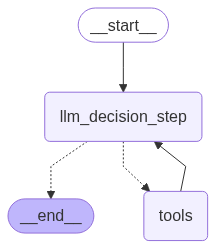

In [66]:
from IPython.display import Image, display
display(Image(TravelAgent.get_graph().draw_mermaid_png()))

#### If workflow is failed then call below fallback function

In [55]:
def contigency_planner_Call(self, user_input: str) -> str:
    """Fallback method if workflow fails"""
    fallback_prompt = f"""
    Create a complete travel plan for: {user_input}
    
    Provide a comprehensive response including:
    - Daily itinerary
    - Top attractions
    - Restaurant recommendations  
    - Cost estimates
    - Weather information
    - Transportation details
    
    Format your response in clean Markdown with proper headers, lists, and formatting.
    Use your knowledge to provide helpful estimates even without real-time data.
    """
    
    messages = [system_prompt, HumanMessage(content=fallback_prompt)]
    response = llm_with_tools.invoke(messages)
    return response.content

In [76]:
def Trip_Planner_Call(user_input: str, max_iterations: int = 5) -> str:
    """Main function to plan a trip with iteration control"""
    messages = [HumanMessage(content=user_input)]
    
    # Add iteration counter to prevent infinite loops
    config = {"recursion_limit": max_iterations}
    
    try:
        response = TravelAgent.invoke({"messages": messages}, config=config)
        final_response = response["messages"][-1].content

        # Final check - if still incomplete, force a summary
        if len(final_response) < 800:
            summary_prompt = f"""
            Based on all the information gathered, provide a COMPLETE travel summary now. 
            Don't use tools anymore. Use the information you have to create a comprehensive plan.
            Format your response in clean Markdown with proper headers, lists, and formatting.
            Original request: {user_input}
            """
                
            summary_messages = response["messages"] + [HumanMessage(content=summary_prompt)]
            final_response_obj = llm_with_tools.invoke(summary_messages)
            return final_response_obj.content
            
        return final_response
    
    except Exception as e:
            print(f"Workflow error: {e}")
            # Fallback - direct LLM call
            return contigency_planner_Call(user_input)
            

#### Convert response in file

In [75]:
def export_to_file(self, response_text: str, filename: str = "travel_plan.md") -> str:
    """Export travel plan to Markdown file with proper formatting"""
    from datetime import datetime
    
    # Create markdown content with metadata header
    markdown_content = f"""# 🌍 AI Travel Plan

    **Generated:** {datetime.now().strftime('%Y-%m-%d at %H:%M')}  
    **Created by:** Nilesh Agent

    ---

    {response_text}

    ---

    *This travel plan was generated by AI. Please verify all information, especially prices, operating hours, and travel requirements before your trip.*
    """
        
    try:
        # Write to markdown file with UTF-8 encoding
        with open(filename, 'w', encoding='utf-8') as f:
            f.write(markdown_content)
        
        print(f"✅ Markdown file saved as: {filename}")
        return filename
        
    except Exception as e:
        print(f"❌ Error saving markdown file: {e}")
        return None

#### User Request/query for required information

In [77]:
user_qeuery = "give me  a detailed 4-day trip itenary to srilanka including best view hotels historic places best food restaurants" \
" with  budget of 400 dollars i need budget converted to indian rupees"

try:
    # Use enhanced planning method
    response = Trip_Planner_Call(user_qeuery, max_iterations=5)
    
    # Export to Markdown directly - no console spam
    
    from datetime import datetime
    filename = f"AI_travel_plan_{i}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.md"
    saved_file = export_to_file(response, filename)
    
    if saved_file:
        print(f"✅ Travel plan generated successfully!")
        print(f"📄 Saved as: {saved_file}")
        print(f"📊 Plan length: {len(response)} characters")
    else:
        print("❌ Failed to save markdown file")
    
    
except Exception as e:
    print(f"❌ Error generating travel plan: {str(e)}")



Workflow error: Recursion limit of 5 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT
❌ Error generating travel plan: contigency_planner_Call() missing 1 required positional argument: 'user_input'


In [71]:
response

'# 4-Day Travel Itinerary to Colombo, Sri Lanka\n\n### Budget:\nYour total budget is $400 which equals 34,720 Indian Rupees.\n\n### Transportation:\nIn Colombo, you can use local taxis or ride-hailing services like Uber and PickMe. The availability might depend on the area, but they can be a good option for longer distances.\n\n### Weather:\n- Current temperature: 28.32°C with Light Rain. \n- Average temperature forecast for the next 3 days:\n  - 2025-06-21: 26.94°C \n  - 2025-06-22: 27.15°C \n  - 2025-06-23: 27.16°C \n\n### Accommodation:\nYou will be staying at a 3-star hotel. The average price per night ranges from $77 and with 4 days, your total accommodation cost would be around $308 (or 26,770 INR).\n\n### Daily Itinerary:\n- **Day 1:** Visit Gangaramaya Temple and Independence Square. Both these places offer a unique insight into the historical and cultural significance of the city.\n- **Day 2:** Experience the remarkable views from Colombo Lotus Tower and delve into serene surr

In [51]:

response = TravelAgent.invoke({"messages":message})

In [72]:
for m in response["messages"]:
    m.pretty_print()

TypeError: string indices must be integers, not 'str'